In [1]:
from pyspark.context import SparkContext
from pyspark.sql.functions import monotonically_increasing_id, sum, count
from pyspark.sql.session import SparkSession
from pyspark.sql.types import IntegerType
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2
from scipy import stats
import statsmodels

sc = SparkContext.getOrCreate()
spark = SparkSession.builder.appName('local').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/03/14 10:19:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/03/14 10:19:41 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
gold_path = 'golden_layer'
fig_path = 'visualization_layer'
logs = spark.read.option("header", True).csv( "Staging/log_output.csv")
reviews = spark.read.option("header", True).csv('Staging/movie_output.csv')
purchases = spark.read.option("header", True).csv('raw/user_purchase.csv')
df2 = pd.read_csv('raw/user_purchase.csv')

## Dim tables and Fact table

#### dim_devices

In [3]:
dim_device = logs[["device"]].distinct()
dim_device = dim_device.withColumn("device_id", monotonically_increasing_id())
dim_device = dim_device.withColumnRenamed("device", "device_name")
dim_device[["device_id", "device_name"]].show(5)
dim_device[["device_id", "device_name"]].write.option("header", True).mode('overwrite').csv(gold_path + "/devices")


+---------+-----------+
|device_id|device_name|
+---------+-----------+
|        0|   Computer|
|        1|     Mobile|
|        2|     Tablet|
+---------+-----------+



#### dim_os

In [4]:
dim_os = logs[["os"]].distinct()
dim_os = dim_os.withColumn("os_id", monotonically_increasing_id())
dim_os = dim_os.withColumnRenamed("os", "os_name")
dim_os[["os_id", "os_name"]].show(5)
dim_os[["os_id", "os_name"]].write.option("header", True).mode('overwrite').csv(gold_path + "/os")

+-----+-----------------+
|os_id|          os_name|
+-----+-----------------+
|    0|Microsoft Windows|
|    1|            Linux|
|    2|        Apple iOS|
|    3|      Apple MacOS|
|    4|   Google Android|
+-----+-----------------+



#### dim_date

In [5]:

dim_date = logs[["logDate"]].distinct()
dim_date = dim_date.withColumn("date_id", monotonically_increasing_id())
dim_date = dim_date.withColumnRenamed("logDate", "logDate_name")
dim_date[["date_id", "logDate_name"]].show(5)
dim_date[["date_id", "logDate_name"]].write.option("header", True).mode('overwrite').csv(gold_path + "/date")


+-------+------------+
|date_id|logDate_name|
+-------+------------+
|      0|  05-01-2021|
|      1|  05-04-2021|
|      2|  04-06-2021|
|      3|  08-10-2021|
|      4|  03-08-2021|
+-------+------------+
only showing top 5 rows



#### dim_location

In [6]:
dim_location = logs[["location"]].distinct()
dim_location = dim_location.withColumn("location_id", monotonically_increasing_id())
dim_location = dim_location.withColumnRenamed("location", "location_name")
dim_location[["location_id", "location_name"]].show(5)
dim_location[["location_id", "location_name"]].write.option("header", True).mode('overwrite').csv(gold_path + "/location")

+-----------+-------------+
|location_id|location_name|
+-----------+-------------+
|          0|         Utah|
|          1|       Hawaii|
|          2|    Minnesota|
|          3|         Ohio|
|          4|       Oregon|
+-----------+-------------+
only showing top 5 rows



#### dim_browser

In [7]:
dim_browser = logs[["browser"]].distinct()
dim_browser = dim_browser.withColumn("browser_id", monotonically_increasing_id())
dim_browser = dim_browser.withColumnRenamed("browser", "browser_name")
dim_browser[["browser_id", "browser_name"]].show(5)
dim_browser[["browser_id", "browser_name"]].write.option("header", True).mode('overwrite').csv(gold_path + "/browser")

+----------+--------------+
|browser_id|  browser_name|
+----------+--------------+
|         0|Microsoft Edge|
|         1|       Firefox|
|         2|        Safari|
|         3| Google Chrome|
+----------+--------------+



In [8]:
sub_review = reviews.join(logs, 'id_review')
sub_review.show(1, False, True)

-RECORD 0-----------------------
 id_review       | 1            
 cid             | 13756        
 positive_review | 0            
 ts              | 2022-03-10   
 logDate         | 04-25-2021   
 phoneNumber     | 821-540-5777 
 device          | Mobile       
 location        | Kansas       
 os              | Apple iOS    
 ipAddress       | 9.200.232.57 
 browser         | Safari       
only showing top 1 row



In [9]:
review = reviews.join(logs, 'id_review')
review = review.join(dim_location, review.location == dim_location.location_name)
review = review.join(dim_browser, review.browser == dim_browser.browser_name)
review = review.join(dim_device, review.device == dim_device.device_name)
review = review.join(dim_date, review.logDate == dim_date.logDate_name)
review = review.join(dim_os, review.os == dim_os.os_name)
review.show(1, False, True)

-RECORD 0-----------------------
 id_review       | 1            
 cid             | 13756        
 positive_review | 0            
 ts              | 2022-03-10   
 logDate         | 04-25-2021   
 phoneNumber     | 821-540-5777 
 device          | Mobile       
 location        | Kansas       
 os              | Apple iOS    
 ipAddress       | 9.200.232.57 
 browser         | Safari       
 location_name   | Kansas       
 location_id     | 27           
 browser_name    | Safari       
 browser_id      | 2            
 device_name     | Mobile       
 device_id       | 1            
 logDate_name    | 04-25-2021   
 date_id         | 135          
 os_name         | Apple iOS    
 os_id           | 2            
only showing top 1 row



In [10]:
review = review.withColumn("positive_review", review["positive_review"].cast(IntegerType()))
review = review.select(
        "id_review",
        "cid",
        "positive_review",
        "location_id",
        "browser_id",
        "device_id",
        "date_id",
        "os_id",
        'ts'
        )
review.write.option("header", True).mode('overwrite').csv(gold_path + "/review")

In [11]:
review.show(5)

+---------+-----+---------------+-----------+----------+---------+-------+-----+----------+
|id_review|  cid|positive_review|location_id|browser_id|device_id|date_id|os_id|        ts|
+---------+-----+---------------+-----------+----------+---------+-------+-----+----------+
|        1|13756|              0|         27|         2|        1|    135|    2|2022-03-10|
|        2|15738|              0|          4|         3|        2|    161|    4|2022-03-10|
|        3|15727|              0|          2|         2|        2|    196|    2|2022-03-10|
|        4|17954|              0|          5|         2|        2|    162|    3|2022-03-10|
|        5|16579|              1|         37|         1|        2|     84|    1|2022-03-10|
+---------+-----+---------------+-----------+----------+---------+-------+-----+----------+
only showing top 5 rows



In [12]:
# purchases = purchases.filter(purchases.Quantity >= 0)
purchases = purchases.withColumn("UnitPrice", purchases["UnitPrice"].cast(IntegerType()))\
            .withColumn("Quantity", purchases["Quantity"].cast(IntegerType())) 
purchases = purchases.withColumn("MoneySpent", purchases.Quantity * purchases.UnitPrice)


In [13]:
customer = purchases.groupBy("CustomerID").sum("MoneySpent")
customer.show(5)

+----------+---------------+
|CustomerID|sum(MoneySpent)|
+----------+---------------+
|     16250|            248|
|     15574|            528|
|     15555|           2737|
|     15271|           1712|
|     17757|           3544|
+----------+---------------+
only showing top 5 rows



In [14]:
temp_table = review.groupBy("cid").agg(sum("positive_review"), count("positive_review"))
temp_table.show(5)


+-----+--------------------+----------------------+
|  cid|sum(positive_review)|count(positive_review)|
+-----+--------------------+----------------------+
|16250|                  25|                    97|
|15555|                  49|                   121|
|15574|                  58|                   136|
|15271|                  43|                    99|
|17757|                  36|                   103|
+-----+--------------------+----------------------+
only showing top 5 rows



In [15]:
customer = customer.join(temp_table, customer.CustomerID == temp_table.cid).drop(customer.CustomerID)
customer = customer.withColumnRenamed("sum(positive_review)", "num_pos_reviews")\
    .withColumnRenamed("count(positive_review)", "num_reviews")\
    .withColumnRenamed("sum(MoneySpent)", "amount_spent")

customer.show(5)
print(customer.count())
customer.write.option("header", True).mode('overwrite').csv(gold_path + "/customer")

+------------+-----+---------------+-----------+
|amount_spent|  cid|num_pos_reviews|num_reviews|
+------------+-----+---------------+-----------+
|         248|16250|             25|         97|
|        2737|15555|             49|        121|
|         528|15574|             58|        136|
|        1712|15271|             43|         99|
|        3544|17757|             36|        103|
+------------+-----+---------------+-----------+
only showing top 5 rows



908


In [16]:
main = customer.join(review, 'cid')
main.show(10)

+-----+------------+---------------+-----------+---------+---------------+-----------+----------+---------+-------+-----+----------+
|  cid|amount_spent|num_pos_reviews|num_reviews|id_review|positive_review|location_id|browser_id|device_id|date_id|os_id|        ts|
+-----+------------+---------------+-----------+---------+---------------+-----------+----------+---------+-------+-----+----------+
|12347|        3012|             44|        131|      938|              0|         27|         2|        1|    270|    3|2022-03-10|
|12347|        3012|             44|        131|      972|              0|         14|         2|        0|    121|    3|2022-03-10|
|12347|        3012|             44|        131|     2612|              0|         11|         0|        1|     22|    0|2022-03-10|
|12347|        3012|             44|        131|     2719|              0|         32|         3|        1|    288|    4|2022-03-10|
|12347|        3012|             44|        131|     4144|           

In [17]:
master = customer.join(sub_review, 'cid')
master.show(10)
master.count()

+-----+------------+---------------+-----------+---------+---------------+----------+----------+------------+--------+-------------+-----------------+------------+--------------+
|  cid|amount_spent|num_pos_reviews|num_reviews|id_review|positive_review|        ts|   logDate| phoneNumber|  device|     location|               os|   ipAddress|       browser|
+-----+------------+---------------+-----------+---------+---------------+----------+----------+------------+--------+-------------+-----------------+------------+--------------+
|12347|        3012|             44|        131|      938|              0|2022-03-10|07-10-2021|773-490-0967|  Mobile|       Kansas|      Apple MacOS|9.200.232.57|        Safari|
|12347|        3012|             44|        131|      972|              0|2022-03-10|06-16-2021|485-654-6963|Computer|     Oklahoma|      Apple MacOS|9.200.232.57|        Safari|
|12347|        3012|             44|        131|     2612|              0|2022-03-10|01-20-2021|200-303-6

99907

## Answer main questions

In [18]:
df = master.toPandas()
df

,cid,amount_spent,num_pos_reviews,num_reviews,id_review,positive_review,ts,logDate,phoneNumber,device,location,os,ipAddress,browser
0,12347,3012,44,131,938,0,2022-03-10,07-10-2021,773-490-0967,Mobile,Kansas,Apple MacOS,9.200.232.57,Safari
1,12347,3012,44,131,972,0,2022-03-10,06-16-2021,485-654-6963,Computer,Oklahoma,Apple MacOS,9.200.232.57,Safari
2,12347,3012,44,131,2612,0,2022-03-10,01-20-2021,200-303-6152,Mobile,Nevada,Microsoft Windows,9.200.232.57,Microsoft Edge
3,12347,3012,44,131,2719,0,2022-03-10,05-23-2021,127-879-7425,Mobile,Lousiana,Google Android,9.200.232.57,Google Chrome
4,12347,3012,44,131,4144,0,2022-03-10,08-13-2021,942-645-2732,Mobile,Oklahoma,Linux,9.200.232.57,Firefox
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99902,18269,94,37,113,95573,0,2022-03-10,06-13-2021,146-344-1605,Tablet,Missouri,Microsoft Windows,9.200.232.57,Microsoft Edge
99903,18269,94,37,113,96223,0,2022-03-10,02-20-2021,984-418-7929,Tablet,New Jersey,Google Android,9.200.232.57,Google Chrome
99904,18269,94,37,113,96624,1,2022-03-10,07-05-2021,245-491-4022,Computer,California,Apple iOS,9.200.232.57,Safari
99905,18269,94,37,113,96976,0,2022-03-10,10-23-2021,554-502-8104,Mobile,Washington,Apple iOS,9.200.232.57,Safari


#### How many reviews were done in California, NY and Texas?

In [19]:
# df.location.unique()
Q1 = df[df.location.isin(['California', 'Texas', 'New York'])] \
        .groupby('location').count()[['cid']]
Q1.rename(columns = {'cid': 'count'}, inplace = True)
Q1.head()

,count
location,
California,2057
New York,1957
Texas,2015


#### How many reviews were done in California, NY, and Texas with an apple device? And how many for each device type?

In [20]:
# df.location.unique()
Q2 = df[ df.location.isin(['California', 'Texas', 'New York'])] \
        .groupby(['location', 'device']).count()[['cid']]
Q2.rename(columns = {'cid': 'Count'}, inplace = True)
Q2

Count
location   device         
California Computer    698
           Mobile      703
           Tablet      656
New York   Computer    640
           Mobile      661
           Tablet      656
Texas      Computer    638
           Mobile      650
           Tablet      727

#### Which location has more reviews from a computer in a Chrome browser?

In [21]:
Q3 = df[ (df.device == 'Computer') & (df.browser == 'Google Chrome')] \
        .groupby('location').count()[['cid']] \
        .sort_values('cid', ascending =False)
Q3.rename(columns = {'cid': 'Count - Chrome Browser'}, inplace = True)
Q3.head()

,Count - Chrome Browser
location,
Massachussets,159
Montana,156
South Dakota,154
Nevada,151
Washington,148


#### What are the states with more and fewer reviews in 2021?

In [22]:
Q4 = df.groupby('location').count()[['cid']]\
    .loc[['Georgia', 'Vermont']]
Q4.rename(columns = {'cid': 'Count'}, inplace = True)
Q4.head()


,Count
location,
Georgia,2100
Vermont,1888


#### Which device is the most used to write reviews in the east and which one in the west?

In [23]:
west = ['Alaska', 'Arizona','California', 'Colorado', 'Hawaii', 'Idaho', 'Montana', 'Nevada', 'New Mexico', 
            'Oregon', 'Utah', 'Washington', 'Wyoming']
east = ['Maine', 'New Hampshire', 'Massachusetts', 'Rhode Island', 'Connecticut',' New York', 'New Jersey', 
            'Delaware', 'Maryland', 'Virginia',' North Carolina', 'South Carolina', 'Georgia', 'Florida']

Q5_west = df[df.location.isin(west)].groupby('device').count()[['cid']] \
            .sort_values('cid', ascending = False)
Q5_west.rename(columns = {'cid': 'Count - West'}, inplace = True)
Q5_west.head()

,Count - West
device,
Mobile,8853
Tablet,8680
Computer,8657


In [24]:
Q5_east = df[df.location.isin(east)].groupby('device').count()[['cid']] \
            .sort_values('cid', ascending = False)
Q5_east.rename(columns = {'cid': 'Count - East'}, inplace = True)
Q5_east.head()

,Count - East
device,
Mobile,7347
Tablet,7347
Computer,7289


## More Analytics

In [25]:
df.describe()


,amount_spent,num_pos_reviews,num_reviews
count,99907.000000,99907.000000,99907.000000
mean,3347.844405,36.400703,110.956219
std,12485.552927,6.208045,10.118933
min,-1024.000000,21.000000,81.000000
25%,357.000000,32.000000,104.000000
50%,1068.000000,36.000000,111.000000
75%,2604.000000,41.000000,118.000000
max,220769.000000,58.000000,141.000000


In [26]:
df.groupby('browser')[['amount_spent', 'num_pos_reviews', 'num_reviews']].median()

,amount_spent,num_pos_reviews,num_reviews
browser,,,
Firefox,1069.0,36.0,111.0
Google Chrome,1080.0,36.0,111.0
Microsoft Edge,1068.0,36.0,111.0
Safari,1068.0,36.0,111.0


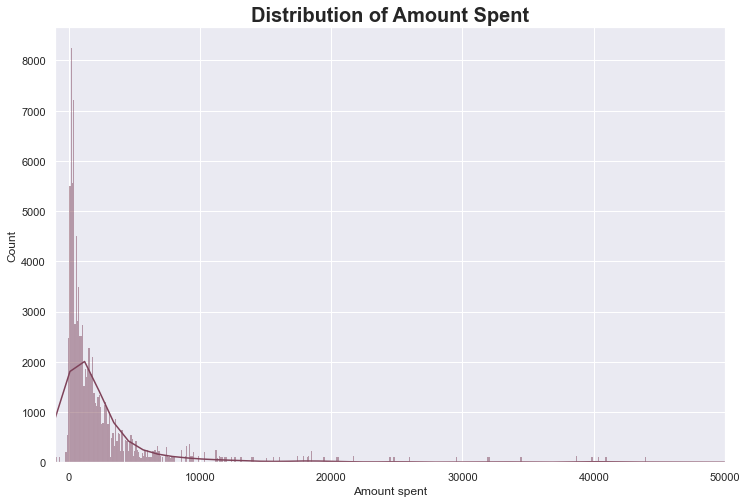

In [27]:
sns.set()  
plt.figure(figsize = (12,8))  
sns.histplot(df.amount_spent, color=[126/255, 66/255, 89/255], kde = True)\
    .set_title('Distribution of Amount Spent', fontdict = {'fontsize': 20, 'weight' :'bold'}) 
plt.xlim([-1024, 50000])
plt.xlabel('Amount spent', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.savefig(fig_path + '/DistributionOfAmountSpent' + '.svg' , dpi = 800) 
plt.show()

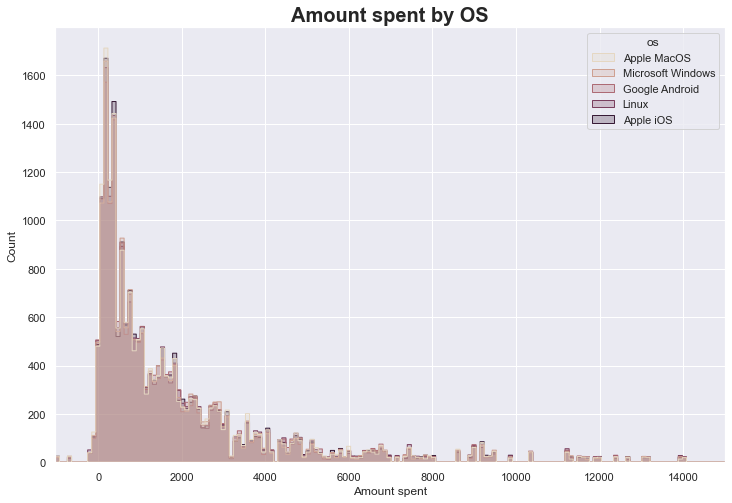

In [28]:
plt.figure(figsize = (12,8))
sns.histplot(x = df.amount_spent, hue = df.os, palette="ch:.25",  element="step")\
    .set_title('Amount spent by OS', fontdict = {'fontsize': 20, 'weight' :'bold'}) 
plt.xlim([df.amount_spent.min(), 15000])

plt.xlabel('Amount spent', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.savefig(fig_path + '/DistributionOfAmountSpentOS' + '.svg' , dpi = 800) 
plt.show()

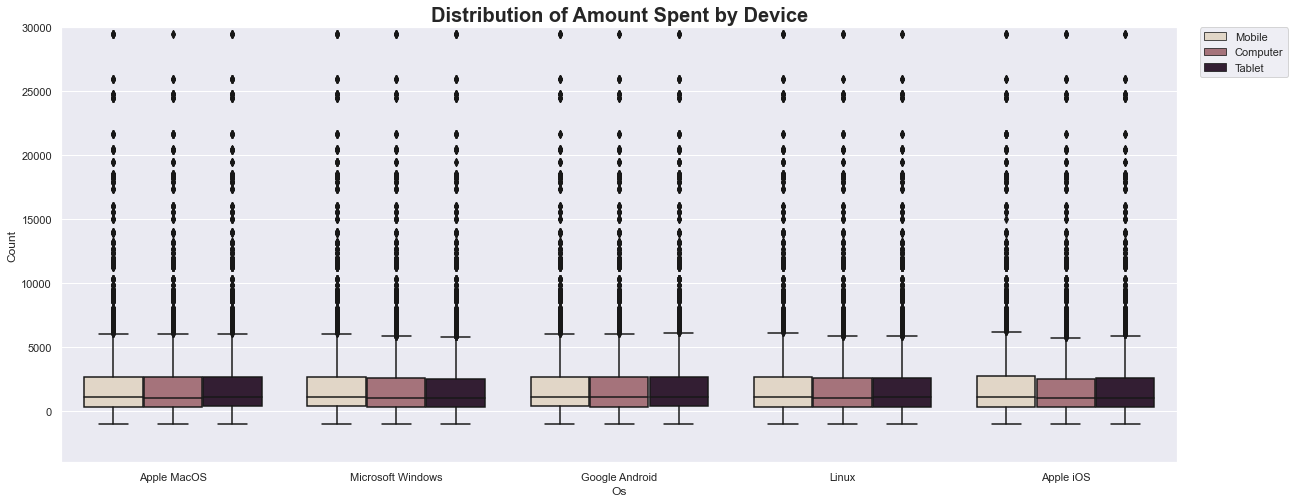

In [29]:
plt.figure(figsize = (20,8))
sns.boxplot(x = 'os', hue = 'device', y = 'amount_spent', data = df, palette="ch:.25") \
    .set_title('Distribution of Amount Spent by Device', fontdict = {'fontsize': 20, 'weight' :'bold'}) 
plt.ylim([-4000, 30000]) 
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Os', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.savefig(fig_path + '/BoxPlotfAmountSpentOSDevice' + '.svg' , dpi = 800) 
plt.show()

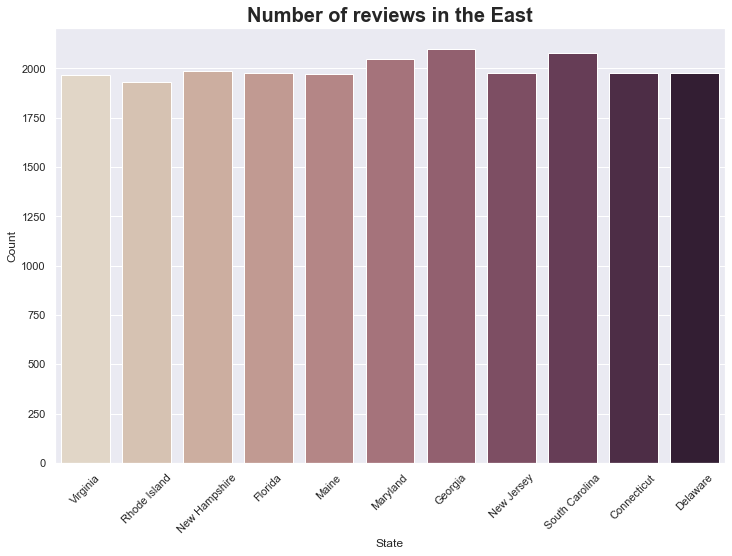

In [30]:
plt.figure(figsize = (12,8))
sns.countplot(x="location", palette="ch:.25", data = df[df.location.isin(east)])\
    .set_title('Number of reviews in the East', fontdict = {'fontsize': 20, 'weight' :'bold'})
plt.xlabel('State', fontsize = 12)
plt.xticks(rotation=45)
plt.ylabel('Count', fontsize = 12)
plt.savefig(fig_path + '/BarPlotReviewEast' + '.svg' , dpi = 800) 
plt.show()

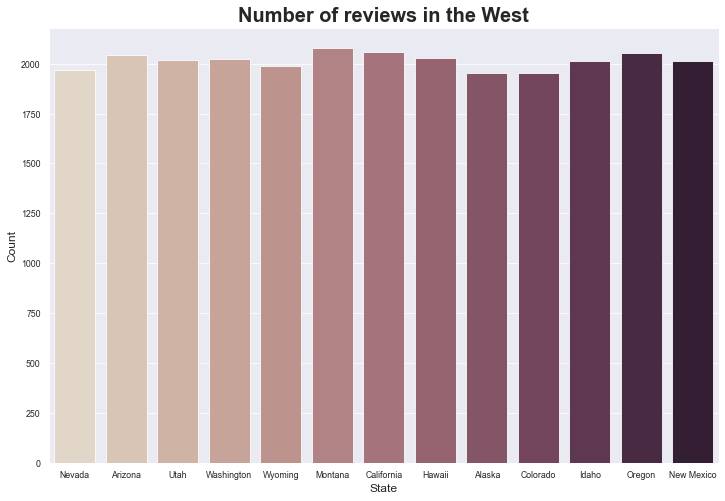

In [31]:
sns.set_context("paper", rc={"font.size":10,"axes.titlesize":12,"axes.labelsize":5})   
plt.figure(figsize = (12,8))
sns.countplot(x="location", palette="ch:.25", data = df[df.location.isin(west)])\
    .set_title('Number of reviews in the West', fontdict = {'fontsize': 20, 'weight' :'bold'})
plt.xlabel('State', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.savefig(fig_path + '/BarPlotReviewWest' + '.svg' , dpi = 800) 
plt.show()

In [32]:
df_states = df[df.location.isin(west + east)]
df_states['zone'] = df_states.location.apply(lambda state : 'east' if state in east else 'west')

/var/folders/p8/hcc3hbg92yvd4fclbgllz3380000gn/T/ipykernel_32702/858473174.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_states['zone'] = df_states.location.apply(lambda state : 'east' if state in east else 'west')


In [33]:
df_states.head(3)

,cid,amount_spent,num_pos_reviews,num_reviews,id_review,positive_review,ts,logDate,phoneNumber,device,location,os,ipAddress,browser,zone
2,12347,3012,44,131,2612,0,2022-03-10,01-20-2021,200-303-6152,Mobile,Nevada,Microsoft Windows,9.200.232.57,Microsoft Edge,west
5,12347,3012,44,131,4345,1,2022-03-10,10-03-2021,251-060-2189,Mobile,Virginia,Apple iOS,9.200.232.57,Safari,east
7,12347,3012,44,131,4646,1,2022-03-10,06-17-2021,352-562-3858,Tablet,Arizona,Microsoft Windows,9.200.232.57,Microsoft Edge,west


In [34]:
df_positives_zone = df_states.groupby(['zone','positive_review']).count()[['cid']]
df_positives_zone.rename(columns = {'cid': 'count'}, inplace = True)
df_positives_zone

count
zone positive_review       
east 0                14803
     1                 7180
west 0                17703
     1                 8487

In [35]:
df

,cid,amount_spent,num_pos_reviews,num_reviews,id_review,positive_review,ts,logDate,phoneNumber,device,location,os,ipAddress,browser
0,12347,3012,44,131,938,0,2022-03-10,07-10-2021,773-490-0967,Mobile,Kansas,Apple MacOS,9.200.232.57,Safari
1,12347,3012,44,131,972,0,2022-03-10,06-16-2021,485-654-6963,Computer,Oklahoma,Apple MacOS,9.200.232.57,Safari
2,12347,3012,44,131,2612,0,2022-03-10,01-20-2021,200-303-6152,Mobile,Nevada,Microsoft Windows,9.200.232.57,Microsoft Edge
3,12347,3012,44,131,2719,0,2022-03-10,05-23-2021,127-879-7425,Mobile,Lousiana,Google Android,9.200.232.57,Google Chrome
4,12347,3012,44,131,4144,0,2022-03-10,08-13-2021,942-645-2732,Mobile,Oklahoma,Linux,9.200.232.57,Firefox
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99902,18269,94,37,113,95573,0,2022-03-10,06-13-2021,146-344-1605,Tablet,Missouri,Microsoft Windows,9.200.232.57,Microsoft Edge
99903,18269,94,37,113,96223,0,2022-03-10,02-20-2021,984-418-7929,Tablet,New Jersey,Google Android,9.200.232.57,Google Chrome
99904,18269,94,37,113,96624,1,2022-03-10,07-05-2021,245-491-4022,Computer,California,Apple iOS,9.200.232.57,Safari
99905,18269,94,37,113,96976,0,2022-03-10,10-23-2021,554-502-8104,Mobile,Washington,Apple iOS,9.200.232.57,Safari


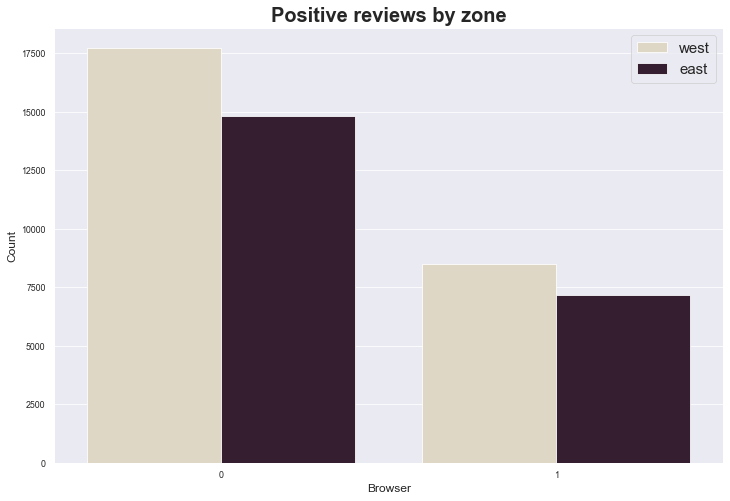

In [36]:
plt.figure(figsize = (12,8))
sns.countplot(x = 'positive_review', hue = 'zone',data = df_states, palette="ch:.33") \
    .set_title('Positive reviews by zone', fontdict = {'fontsize': 20, 'weight' :'bold'}) 
plt.legend(fontsize = 15)
plt.xlabel('Browser', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.savefig(fig_path + '/PositiveReviewsByZone' + '.svg' , dpi = 800) 
plt.show()

## Some regression stuff

In [37]:
reg_df = df.drop_duplicates(['cid'])
reg_df['positive_review'] = reg_df['positive_review'].astype(int)
reg_df_numerical = reg_df[['cid','amount_spent' ,'num_pos_reviews',	'num_reviews']]
reg_df_numerical = reg_df[['cid','amount_spent' ,'num_pos_reviews',	'num_reviews']]



/var/folders/p8/hcc3hbg92yvd4fclbgllz3380000gn/T/ipykernel_32702/1139295893.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_df['positive_review'] = reg_df['positive_review'].astype(int)


In [38]:
def mahalanobis(x=None, data=None, cov=None):
    x_mu = x - np.mean(data, axis = 0)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left = np.dot(x_mu, inv_covmat)
    mahal = np.dot(left, x_mu.T)
    return mahal.diagonal()

In [39]:
reg_df['mahalanobis'] = mahalanobis(x=reg_df[['amount_spent' ,'num_pos_reviews',	'num_reviews']], 
                            data=reg_df[['amount_spent' ,'num_pos_reviews','num_reviews']])
reg_df['p_val'] = 1 - chi2.cdf(reg_df['mahalanobis'], 2)

/var/folders/p8/hcc3hbg92yvd4fclbgllz3380000gn/T/ipykernel_32702/1806988772.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_df['mahalanobis'] = mahalanobis(x=reg_df[['amount_spent' ,'num_pos_reviews',	'num_reviews']],
/var/folders/p8/hcc3hbg92yvd4fclbgllz3380000gn/T/ipykernel_32702/1806988772.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_df['p_val'] = 1 - chi2.cdf(reg_df['mahalanobis'], 2)


In [40]:
reg_df.sort_values('p_val', ascending=False)
reg_df[reg_df.p_val >= 0.05 ]

,cid,amount_spent,num_pos_reviews,num_reviews,id_review,positive_review,ts,logDate,phoneNumber,device,location,os,ipAddress,browser,mahalanobis,p_val
0,12347,3012,44,131,938,0,2022-03-10,07-10-2021,773-490-0967,Mobile,Kansas,Apple MacOS,9.200.232.57,Safari,4.317703,0.115458
131,12386,228,32,93,861,0,2022-03-10,04-02-2021,564-045-7387,Tablet,Arkansas,Apple MacOS,9.200.232.57,Safari,3.093076,0.212984
224,12429,2934,43,114,999,0,2022-03-10,02-05-2021,741-501-1157,Computer,Oklahoma,Linux,9.200.232.57,Firefox,1.375745,0.502644
338,12472,4105,35,102,2105,1,2022-03-10,07-12-2021,118-357-0986,Computer,New York,Apple MacOS,9.200.232.57,Safari,0.763848,0.682547
527,12683,5807,32,113,277,0,2022-03-10,04-24-2021,112-413-6346,Mobile,Nevada,Google Android,9.200.232.57,Google Chrome,1.180385,0.554221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99208,18225,3893,47,120,864,1,2022-03-10,04-27-2021,183-290-2229,Computer,Nevada,Apple MacOS,9.200.232.57,Safari,3.163464,0.205619
99462,18230,2202,38,106,593,1,2022-03-10,08-11-2021,653-347-3312,Computer,New Hampshire,Apple MacOS,9.200.232.57,Safari,0.625573,0.731406
99568,18239,1087,31,110,26,1,2022-03-10,07-16-2021,581-776-4378,Mobile,Florida,Apple MacOS,9.200.232.57,Safari,1.067303,0.586460
99678,18259,2058,41,116,1271,0,2022-03-10,05-14-2021,299-530-3434,Computer,Nevada,Google Android,9.200.232.57,Google Chrome,0.669892,0.715377


<Figure size 864x576 with 0 Axes>

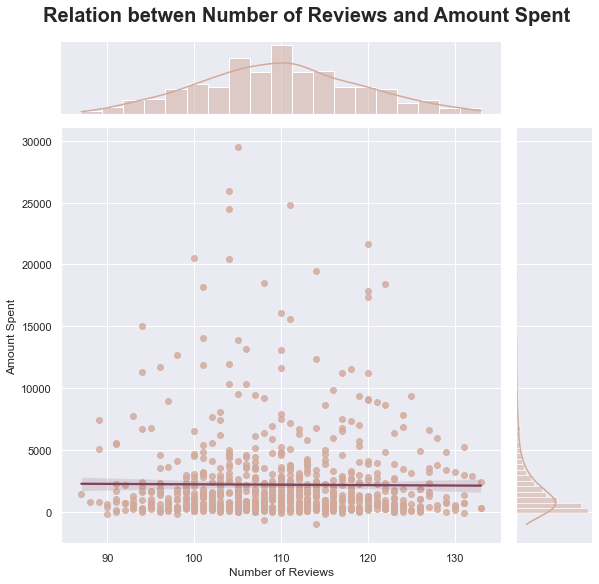

In [41]:
sns.set_theme()
plt.figure(figsize = (12,8)) 
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

join = sns.jointplot(y = 'amount_spent', x = 'num_reviews',data = reg_df[reg_df.p_val >= 0.05 ],
             kind='reg', color=[210/255, 170/255, 155/255] , 
             joint_kws={'line_kws':{'color': [126/255, 66/255, 89/255]}},
             height=8.27)  
join.fig.subplots_adjust(top=.92)
join.fig.suptitle('Relation betwen Number of Reviews and Amount Spent', fontsize = 20, weight ='bold' )
join.set_axis_labels('Number of Reviews', 'Amount Spent' ,fontsize=12)
plt.savefig(fig_path + '/JointPlot_Reviews_Amount' + '.svg' , dpi = 800) 
plt.show()

<Figure size 864x576 with 0 Axes>

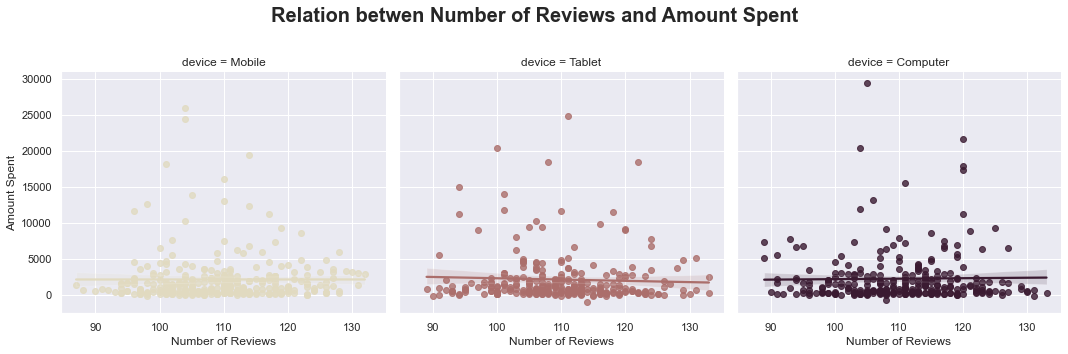

In [42]:
sns.set_theme()  
plt.figure(figsize = (12,8))  
rel = sns.lmplot(y = 'amount_spent', x = 'num_reviews', col = 'device' , 
            hue = 'device',data = reg_df[reg_df.p_val >= 0.05 ] , palette="ch:.35")
        # .set(tittle = 'Relation betwen Number of Reviews and Amount Spent', fontdict = {'fontsize': 20, 'weight' :'bold'}) 
rel.fig.subplots_adjust(top=.8)
rel.fig.suptitle('Relation betwen Number of Reviews and Amount Spent', fontsize = 20, weight ='bold' )
rel.set_axis_labels('Number of Reviews', 'Amount Spent', fontsize=12)
plt.savefig(fig_path + '/lmplot_Reviews_Amount_byDevice' + '.svg' , dpi = 800) 
plt.show()


<Figure size 864x576 with 0 Axes>

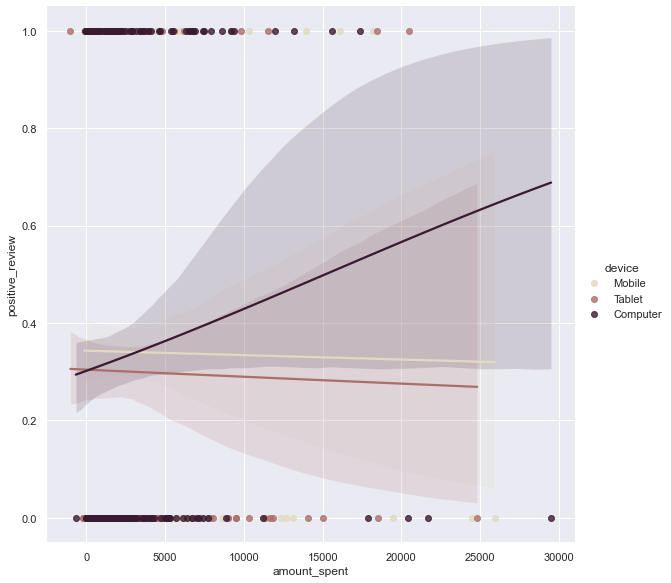

In [44]:
sns.set()  
plt.figure(figsize = (12,8))  
sns.lmplot(y = 'positive_review', x = 'amount_spent',hue = 'device', logistic=True ,data = reg_df[reg_df.p_val >= 0.05 ] , 
        palette="ch:.35" ,height=8.27)  
plt.show()